In [18]:
import requests
import pandas as pd
from geopy.geocoders import Nominatim
import pytz
from datetime import datetime
import numpy as np
from IPython.display import display, clear_output, Markdown
from tabulate import tabulate

devices_api = 'https://api.smartcitizen.me/v0/devices/'

## Workshops Settings

In [19]:
# Workshops sites

places = [{
	'town': 'Bottrop, DE',
	'start_date': '2018-11-01T00:00:00Z',
	'blacklist': [5227]
},
{
	'town': 'Vantaa, FI',
	'start_date': '2018-11-01T00:00:00Z',
	'blacklist': [5075, 5072, 5073, 5071]
},
{
	'town': 'Bologna, IT',
	'start_date': '2018-11-01T00:00:00Z',
    'blacklist': [5033, 5036, 5040, 5034, 5035, 5042, 5037, 5043, 5039, 5038, 5045, 5044, 5041]
},
{
	'town': 'Hasselt, BE',
	'start_date': '2018-11-01T00:00:00Z'
},
{
	'town': 'Surrey, UK',
	'start_date': '2018-11-01T00:00:00Z'
},
{
	'town': 'Dublin, IE',
	'start_date': '2018-12-01T00:00:00Z'
}]

In [20]:
def devices(place):

    geolocator = Nominatim(user_agent="iSCAPE")

    location = geolocator.geocode(place['town'])

    location_str = str(location.latitude) + ',' + str(location.longitude)

    params = {'near': location_str, 'within': 1000, 'per_page': 100}

    req = requests.get(devices_api, params=params).json()
    
    devices = pd.DataFrame(req)
    devices['workshop_start_date'] = pd.to_datetime(place['start_date'])
    devices['iscape_site'] = place['town']
    devices['added_at'] = pd.to_datetime(devices['added_at'])
    devices['last_reading_at'] = pd.to_datetime(devices['last_reading_at'])
    devices = devices[devices['last_reading_at'] > devices['workshop_start_date']]
    devices = devices[devices['added_at'] > devices['workshop_start_date']]

    devices.index = devices['id']

    # Probably this could be done via list comprehension but it's clearer this way
    # The problem comes with the dict within the pandas series, that it's not directly indexable from pandas (same sintax)
    list_kits = list()
    for item in devices.kit:
        if item['id'] == 20: list_kits = devices[devices.kit == item].index
    
    # Filter devices
    devices = devices.loc[list_kits]

    
    # Exclude some devices manually
    if 'blacklist' in place:
        devices = devices.loc[~devices['id'].isin(place['blacklist'])]
    
    devices['total_readings'] = devices.apply(lambda row: readings(row), axis=1)
    
    devices['total_readings_days'] = devices.apply(lambda row: row['total_readings'] / (60.0*24.0), axis = 1)
    devices['total_days_last_reading'] = devices.apply(lambda row: max(0, (row['last_reading_at'] - row['added_at']).days), axis=1)
    devices['total_days_since_registered'] = devices.apply(lambda row: (datetime.now() - row['added_at']).days, axis=1)

    devices['user_name'] = devices.apply(lambda row: row['owner']['username'], axis = 1)
    
    devices['ratio_readings_days'] = devices.apply(lambda row: ratio_days(row), axis = 1)

    devices['town'] = devices.apply(lambda row: row['data']['location']['city'], axis = 1)

    devices['id'] = devices['id'].astype(str)
    return devices

def ratio_days(row):
    return row['total_readings_days'] / row['total_days_since_registered'] if row['total_days_since_registered'] else np.nan

def readings(row):

    params = {'from': row['workshop_start_date'].isoformat(), 'to': datetime.now().isoformat(), 'rollup': '60s', 'sensor_id': 10 }

    req = requests.get(devices_api + str(row['id']) + '/readings', params=params).json()
            
    readings = req['readings']

    total_readings = len(readings)

    return total_readings

In [21]:
sites = []
for place in places:
    
    sites.append(devices(place))
    
sites = pd.concat(sites)
display(sites)   

,added_at,data,description,id,kit,last_reading_at,mac_address,name,owner,state,...,uuid,workshop_start_date,iscape_site,total_readings,total_readings_days,total_days_last_reading,total_days_since_registered,user_name,ratio_readings_days,town
id,,,,,,,,,,,,,,,,,,,,,
5126,2018-11-13 18:20:33,"{u'sensors': [{u'raw_value': 12.47, u'uuid': u...",iSCAPE Citizen Kit,5126,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-13 23:59:58,[FILTERED],Polaris,"{u'username': u'AlexChristian', u'uuid': u'd18...",has_published,...,d44e84fa-1fcc-4d2e-970b-9335bc7c05a6,2018-11-01,"Bottrop, DE",210,0.145833,0,56,AlexChristian,0.002604,Bottrop
5125,2018-11-13 18:19:44,"{u'sensors': [{u'raw_value': 119.44, u'uuid': ...",iSCAPE Citizen Kit,5125,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-13 18:28:04,[FILTERED],#Team Mia Carina,"{u'username': u'Carina Christian', u'uuid': u'...",has_published,...,d1e4a5ef-a100-4f4c-b753-93ef0d0d9b9c,2018-11-01,"Bottrop, DE",17,0.011806,0,56,Carina Christian,0.000211,Bottrop
5128,2018-11-13 18:29:41,"{u'sensors': [{u'raw_value': 107.21, u'uuid': ...",iSCAPE Citizen Kit,5128,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-13 17:31:51,[FILTERED],Bottrop Citizen Science - iSCAPE Team,"{u'username': u'iscape_TUDO_team', u'uuid': u'...",has_published,...,1eb51ac3-34e3-4eea-a5f0-8adb7623b20f,2018-11-01,"Bottrop, DE",63,0.043750,0,56,iscape_TUDO_team,0.000781,Bottrop
5170,2018-11-16 06:33:45,"{u'sensors': [{u'raw_value': 3.6, u'uuid': u'a...",iSCAPE Citizen Kit,5170,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-16 15:07:51,[FILTERED],Yummy Anagram Anagram,"{u'username': u'OFI Gov', u'uuid': u'8bc3c336-...",has_published,...,793c592a-b07d-4015-89df-3f71498980bb,2018-11-01,"Bottrop, DE",512,0.355556,0,54,OFI Gov,0.006584,Bottrop
5138,2018-11-14 16:43:00,"{u'sensors': [{u'raw_value': 38.48, u'uuid': u...",iSCAPE Citizen Kit,5138,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-12-07 07:53:32,[FILTERED],Kit Cat,"{u'username': u'day1patch', u'uuid': u'5d719d7...",has_published,...,071981f4-4503-4eb1-b75c-32a05bd4a5e5,2018-11-01,"Bottrop, DE",8681,6.028472,22,55,day1patch,0.109609,Bottrop
5164,2018-11-15 14:56:57,"{u'sensors': [{u'raw_value': 488.85, u'uuid': ...",iSCAPE Citizen Kit,5164,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-12-07 23:59:37,[FILTERED],Brakerstr. BOT,"{u'username': u'Tilman', u'uuid': u'f7595847-1...",has_published,...,100bf429-733b-46a2-a086-47fea1a51e29,2018-11-01,"Bottrop, DE",37200,25.833333,22,54,Tilman,0.478395,Bottrop
5464,2019-01-07 08:02:19,"{u'sensors': [{u'raw_value': 390.29, u'uuid': ...",iSCAPE Citizen Kit,5464,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2019-01-09 12:29:03,[FILTERED],kafo_pakr,"{u'username': u'pascal.krueger', u'uuid': u'97...",has_published,...,b096282f-d08b-4725-bee7-738346e9a1a7,2018-11-01,"Bottrop, DE",3141,2.181250,2,2,pascal.krueger,1.090625,Bottrop
5398,2018-12-17 14:22:46,"{u'sensors': [{u'raw_value': 131.35, u'uuid': ...",iSCAPE Citizen Kit,5398,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-11-15 23:59:32,[FILTERED],LK-BOT,"{u'username': u'lis.faulenbach91_97', u'uuid':...",has_published,...,dd3868b5-620c-40b6-9d6a-1160f2b9afe2,2018-11-01,"Bottrop, DE",1419,0.985417,0,22,lis.faulenbach91_97,0.044792,Bottrop
5390,2018-12-10 09:59:53,"{u'sensors': [{u'raw_value': 0.51, u'uuid': u'...",iSCAPE Citizen Kit,5390,"{u'description': u'iSCAPE Citizen Kit ', u'upd...",2018-12-03 23:59:39,[FILTERED],Neighborly Playground Stack,"{u'username': u'OFI Gov', u'uuid': u'8bc3c336-...",has_published,...,20ccec8a-deeb-499b-8ed4-7fb5b8644532,2018-11-01,"Bottrop, DE",10789,7.492361,0,30,OFI Gov,0.249745,Bottrop


## Charts report for all sites

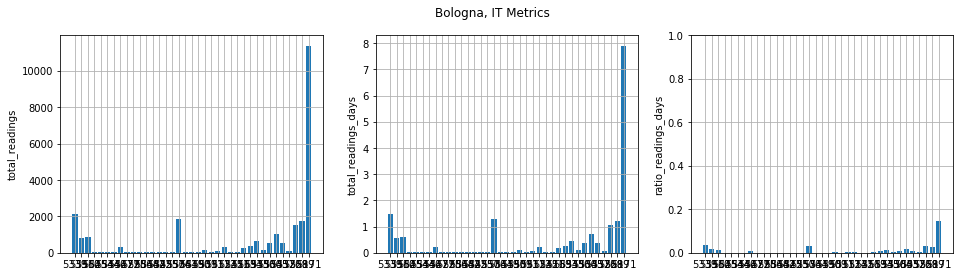

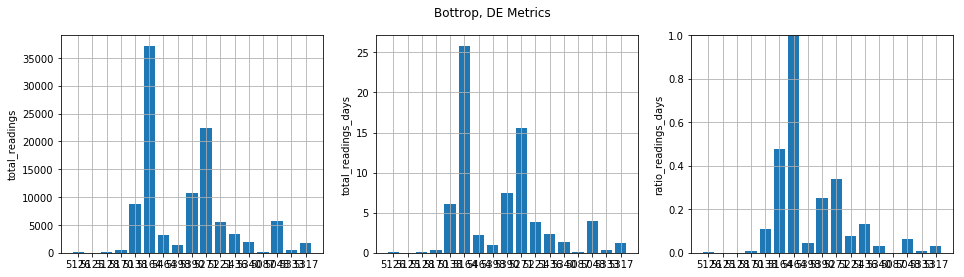

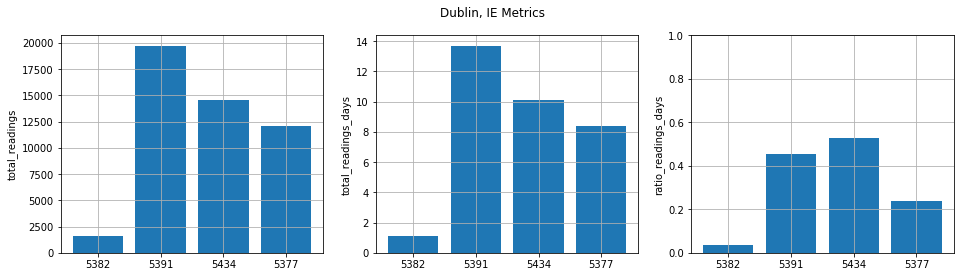

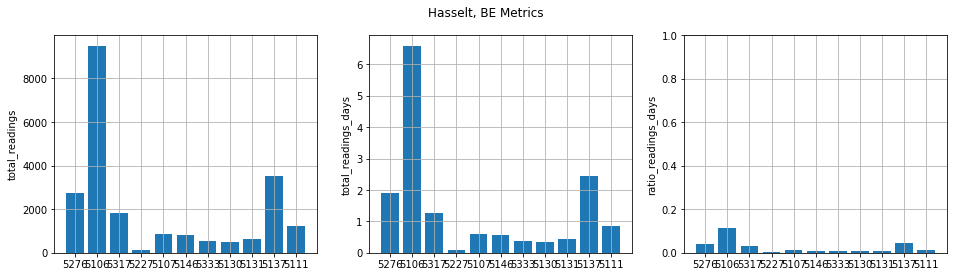

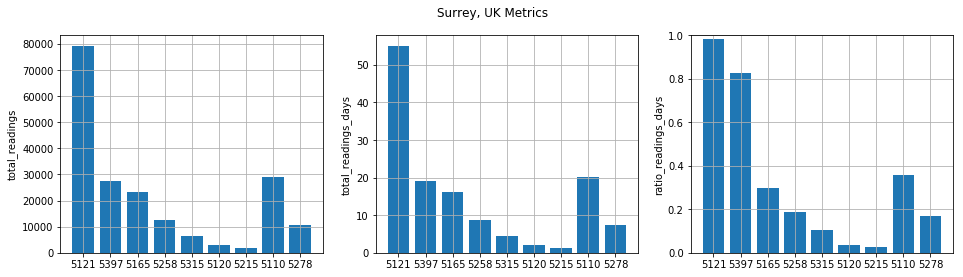

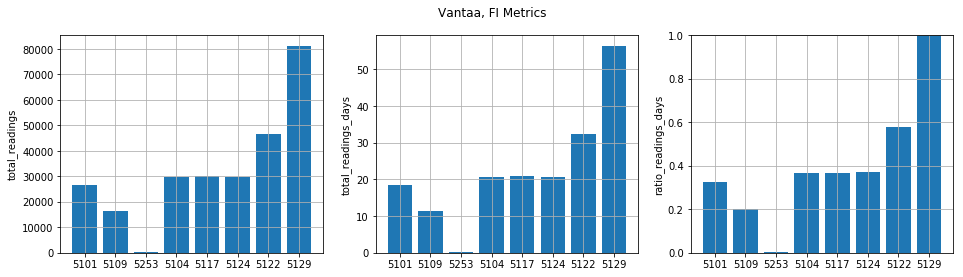

In [22]:
import matplotlib.pyplot as plot
% matplotlib inline

gg = [x for _, x in sites.groupby('iscape_site')]

for i in gg:
    i = i[['id', 'iscape_site', 'ratio_readings_days', 'total_readings', 'total_readings_days', 'total_days_last_reading', 'total_days_since_registered']]
    list_sites =  i['iscape_site'].values
    
    fig, axes = plot.subplots(1, 3, figsize = (16,4))
    print axes
    axes[0].bar(i['id'], i ['total_readings'])
    axes[0].set_ylabel('total_readings')
    axes[0].grid(True)

    axes[1].bar(i['id'], i['total_readings_days'])
    axes[1].set_ylabel('total_readings_days')
    axes[1].grid(True)

    axes[2].bar(i['id'], i['ratio_readings_days'])
    axes[2].set_ylabel('ratio_readings_days')
    axes[2].set_ylim([0, 1])
    axes[2].grid(True)
    fig.suptitle(list_sites[0] + ' Metrics')
    

## Table report for all sites

In [23]:
clean_sites = sites.drop(['data', 'description','added_at','last_reading_at','kit', 'total_days_since_registered', 'total_days_last_reading','mac_address', 'owner', 'state', 'system_tags', 'user_tags', 'uuid', 'updated_at' ], axis=1)  
    
clean_sites = clean_sites.sort_values(['iscape_site', 'total_readings'], ascending=[True, False])

clean_sites.index = clean_sites['id']

clean_sites = clean_sites[['iscape_site', 'name', 'user_name', 'ratio_readings_days', 'total_readings', 'town']]

clean_sites_print = clean_sites.copy()

clean_sites_print['ratio_readings_days'] = pd.Series(["{0:.2f}%".format(val * 100) for val in clean_sites_print['ratio_readings_days']], index = clean_sites.index)    

display(clean_sites_print)   

,iscape_site,name,user_name,ratio_readings_days,total_readings,town
id,,,,,,
5171,"Bologna, IT",Bologna's countryside,outside,14.63%,11380,Lizzano in Belvedere
5339,"Bologna, IT",FDB7_Urban,Urban,3.72%,2140,Bologna
5306,"Bologna, IT",60BC_Hera,HeraPatrizia00,3.10%,1877,Bologna
5299,"Bologna, IT",Cavaioni,SaraR,2.85%,1725,Bologna
5358,"Bologna, IT",Cavaioni,SaraR,2.90%,1503,Casalecchio di Reno
5305,"Bologna, IT",60BC_MurriOutPat,HeraPatrizia00,1.67%,1012,Bologna
5310,"Bologna, IT",090F_test1,SergioNex,1.44%,868,Bologna
5356,"Bologna, IT",458A_test1,SergioNex,1.61%,833,Bologna
5335,"Bologna, IT",60BC_RepubblicaOut,Letizia,1.11%,642,Bologna


## Table report per site 

In [26]:
gg = [x for _, x in sites.groupby('iscape_site')]

for i in gg:
    
    clean_sites = i.drop(['data', 'description','added_at','last_reading_at','kit', 'total_days_last_reading','mac_address', 'owner', 'state', 'system_tags', 'user_tags', 'uuid', 'updated_at' ], axis=1)  
    
    clean_sites = clean_sites.sort_values(['iscape_site', 'total_readings'], ascending=[True, False])

    clean_sites.index = clean_sites['id']

    clean_sites = clean_sites[['iscape_site', 'name', 'user_name', 'total_days_since_registered', 'total_readings', 'ratio_readings_days']]
    
    clean_sites['ratio_readings_days'] = clean_sites.apply(lambda row: row['ratio_readings_days'] if row['ratio_readings_days'] <= 1 else 1, axis=1)
    
    clean_sites_print = clean_sites.copy()
    
    clean_sites_print['ratio_readings_days'] = pd.Series(["{0:.2f}%".format(val * 100) for val in clean_sites_print['ratio_readings_days']], index = clean_sites.index)    

    ## This is temporary for Markdown output...
    
    print '## ' + clean_sites['iscape_site'][0] + ' [' + str(len(i.index)) + ']'
    print '\n'
    
    clean_sites_print = clean_sites_print.drop(['iscape_site'], axis=1)  
    
    
    print tabulate(clean_sites_print, ['Id','Name','Username','Days','Readings','Perf'], tablefmt="html")

    
    print '\n'
    print '\n'

## Bologna, IT [37]


<table>
<thead>
<tr><th style="text-align: right;">  Id</th><th>Name                              </th><th>Username      </th><th style="text-align: right;">  Days</th><th style="text-align: right;">  Readings</th><th>Perf  </th></tr>
</thead>
<tbody>
<tr><td style="text-align: right;">5171</td><td>Bologna's countryside             </td><td>outside       </td><td style="text-align: right;">    54</td><td style="text-align: right;">     11380</td><td>14.63%</td></tr>
<tr><td style="text-align: right;">5339</td><td>FDB7_Urban                        </td><td>Urban         </td><td style="text-align: right;">    40</td><td style="text-align: right;">      2140</td><td>3.72% </td></tr>
<tr><td style="text-align: right;">5306</td><td>60BC_Hera                         </td><td>HeraPatrizia00</td><td style="text-align: right;">    42</td><td style="text-align: right;">      1877</td><td>3.10% </td></tr>
<tr><td style="text-align: right;">5299</td><td>Cavaioni             

## Surrey, UK [9]


<table>
<thead>
<tr><th style="text-align: right;">  Id</th><th>Name                    </th><th>Username            </th><th style="text-align: right;">  Days</th><th style="text-align: right;">  Readings</th><th>Perf  </th></tr>
</thead>
<tbody>
<tr><td style="text-align: right;">5121</td><td>AlienPirate             </td><td>jima                </td><td style="text-align: right;">    56</td><td style="text-align: right;">     79270</td><td>98.30%</td></tr>
<tr><td style="text-align: right;">5110</td><td>Bob's Warm Spark Anagram</td><td>Swampie             </td><td style="text-align: right;">    57</td><td style="text-align: right;">     29185</td><td>35.56%</td></tr>
<tr><td style="text-align: right;">5397</td><td>PK Guildford            </td><td>p.kumar@surrey.ac.uk</td><td style="text-align: right;">    23</td><td style="text-align: right;">     27442</td><td>82.86%</td></tr>
<tr><td style="text-align: right;">5165</td><td>Chris H                 </td><td>shoot2

## Aggregated report for all sites

,id,total_days_since_registered,total_readings,ratio_readings_days
iscape_site,,,,
"Vantaa, FI",8,55,261351,40%
"Surrey, UK",9,47,193645,33%
"Bottrop, DE",17,43,103493,15%
"Dublin, IE",4,29,47883,31%
"Bologna, IT",37,41,25699,1%
"Hasselt, BE",11,51,22343,3%
Total,86,266,654414,40%33%15%31%1%3%


<table>
<thead>
<tr><th>Sites      </th><th style="text-align: right;">  Participants</th><th style="text-align: right;">  Average Days registered</th><th style="text-align: right;">  Total Sensor Readings</th><th>Performance Average  </th></tr>
</thead>
<tbody>
<tr><td>Vantaa, FI </td><td style="text-align: right;">             8</td><td style="text-align: right;">                       55</td><td style="text-align: right;">                 261351</td><td>40%                  </td></tr>
<tr><td>Surrey, UK </td><td style="text-align: right;">             9</td><td style="text-align: right;">                       47</td><td style="text-align: right;">                 193645</td><td>33%                  </td></tr>
<tr><td>Bottrop, DE</td><td style="text-align: right;">            17</td><td style="text-align: right;">                       43</td><td style="text-align: right;">                 103493</td><td>15%                  </td></tr>
<tr><td>Dublin, IE </td><td style="text-align: 

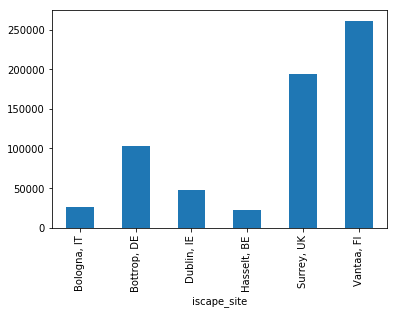

In [27]:
clean_sites = sites.drop(['data', 'description','added_at','last_reading_at','kit', 'total_days_last_reading','mac_address', 'owner', 'state', 'system_tags', 'user_tags', 'uuid', 'updated_at' ], axis=1)  
    
clean_sites = clean_sites.sort_values(['iscape_site', 'total_readings'], ascending=[True, False])

clean_sites.index = clean_sites['id']

clean_sites = clean_sites[['id', 'iscape_site', 'name', 'user_name', 'total_days_since_registered', 'total_readings', 'ratio_readings_days']]
    
clean_sites['ratio_readings_days'] = clean_sites.apply(lambda row: row['ratio_readings_days'] if row['ratio_readings_days'] <= 1 else 1, axis=1)
    
clean_sites_print = clean_sites.copy()
    
clean_sites_print['ratio_readings_days'] = pd.Series(["{0:.2f}%".format(val * 100) for val in clean_sites_print['ratio_readings_days']], index = clean_sites.index)    

sites_total_records2 = clean_sites.groupby(['iscape_site'])['total_readings'].sum()

sites_total_records3 = clean_sites.groupby(['iscape_site'])['ratio_readings_days'].mean()

sites_total_records4 = clean_sites.groupby(['iscape_site'])['total_days_since_registered'].mean()

sites_total_records6 = clean_sites.groupby(['iscape_site'])['id'].count()

sites_total_records2.plot.bar(x='Living Labs', y='Readings')

sites_total_records5 = pd.concat([sites_total_records6, sites_total_records4, sites_total_records2, sites_total_records3], axis=1)

sites_total_records5['total_days_since_registered'] = sites_total_records5['total_days_since_registered'].astype(int)

sites_total_records5['ratio_readings_days'] = pd.Series(["{0:.0f}%".format(val * 100) for val in sites_total_records5['ratio_readings_days']], index = sites_total_records5.index)    

sites_total_records5 = sites_total_records5.sort_values(['total_readings'], ascending=[False])

sites_total_records5.loc['Total']= sites_total_records5.sum()

display(sites_total_records5)

print tabulate(sites_total_records5, ['Sites', 'Participants', 'Average Days registered', 'Total Sensor Readings', 'Performance Average'], tablefmt="html")

